
# Carvana Image Masking Challenge
Automatically identify the boundaries of the car in an image

As with any big purchase, full information and transparency are key. While most everyone describes buying a used car as frustrating, it’s just as annoying to sell one, especially online. Shoppers want to know everything about the car but they must rely on often blurry pictures and little information, keeping used car sales a largely inefficient, local industry.

Carvana, a successful online used car startup, has seen opportunity to build long term trust with consumers and streamline the online buying process.

An interesting part of their innovation is a custom rotating photo studio that automatically captures and processes 16 standard images of each vehicle in their inventory. While Carvana takes high quality photos, bright reflections and cars with similar colors as the background cause automation errors, which requires a skilled photo editor to change.

![](./carvana_graphics.png)

Leaderboard:
https://www.kaggle.com/c/carvana-image-masking-challenge/leaderboard



In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import matplotlib.cm as cm
import scipy.misc
import caffe
import skfmm
import PIL.Image

import lib.imageutl as imutl
import lib.visualizationutl as view
import lib.dataaug as aug

%matplotlib inline
print(caffe.__file__)

/opt/caffe/python/caffe/__init__.pyc


# Data analysis

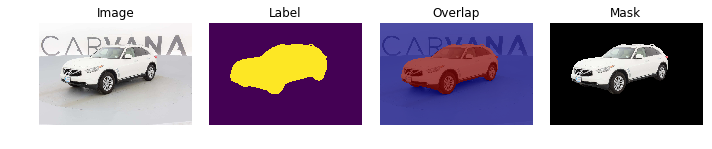

(1280, 1918, 3)


In [5]:
pathdataset = '../db'
namedataset = 'car'
metadata = 'metadata.csv'
pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)

data = imutl.dataProvide( pathname, fn_image='train', fn_label='train_masks', lext='gif')
view.display_image_and_gt( data )
print(data.getimage(0).shape)


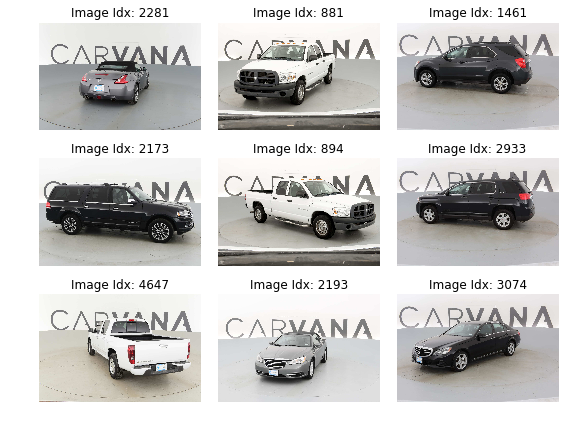

Total image: 5088


In [7]:
view.display_random_images(data)
print('Total image: {}'.format(data.num))

In [8]:
mdata = pd.read_csv(pathmetadata)
mdata.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


# Training 

In [14]:
from caffe import layers as L
from caffe import params as P

def create_arq():
   
    n = caffe.NetSpec()
    n.data, n.label = L.Python( python_param = dict(module='caffelayerpython', layer='carLoaderLayer', 
          param_str='{"src_file": "../db/car", "batch_size":2, "im_shape":100 }' ), ntop=2)
    n.tdata, n.tlabel = L.Python(n.data, n.label, python_param = dict(module='caffelayerpython', layer='augmentationLayer', 
          param_str='{"angle":10, "translation":0.2, "warp":0 }' ), ntop=2)
    
    return 'name: "FCNnet"\n' + str(n.to_proto())

with open('train.prototxt', 'w') as f:
    f.write(create_arq());

#print arq
print(create_arq())


name: "FCNnet"
layer {
  name: "data"
  type: "Python"
  top: "data"
  top: "label"
  python_param {
    module: "caffelayerpython"
    layer: "carLoaderLayer"
    param_str: "{\"src_file\": \"../db/car\", \"batch_size\":2, \"im_shape\":100 }"
  }
}
layer {
  name: "tdata"
  type: "Python"
  bottom: "data"
  bottom: "label"
  top: "tdata"
  top: "tlabel"
  python_param {
    module: "caffelayerpython"
    layer: "augmentationLayer"
    param_str: "{\"angle\":10, \"translation\":0.2, \"warp\":0 }"
  }
}



In [15]:
caffe.set_mode_cpu()
net = caffe.Net('train.prototxt', caffe.TRAIN)
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (2, 3, 100, 100)),
 ('label', (2, 1, 100, 100)),
 ('tdata', (2, 3, 100, 100)),
 ('tlabel', (2, 1, 100, 100))]

['tlabel', 'tdata']
(2, 3, 100, 100)
(2, 1, 100, 100)
[ 0.  1.]


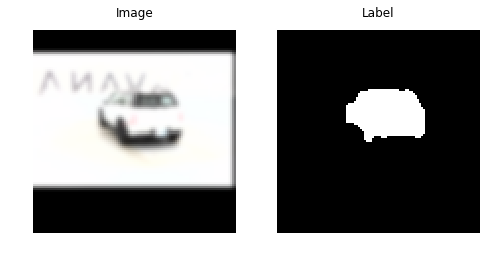

In [20]:
out = net.forward();
print(out.keys())

images = out['tdata'];
labels = out['tlabel'];

print(images.shape)
print(labels.shape)
print( np.unique(labels[1,0,:,:]) )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(images[0,...].transpose(1,2,0) )
ax1.set_title('Image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(labels[0,0,:,:]==1, cmap=plt.cm.gray)
ax2.set_title('Label')
ax1.set_adjustable('box-forced')
plt.show()


In [8]:
# https://github.com/NVIDIA/DIGITS/tree/master/examples/semantic-segmentation
caffe.set_mode_cpu()
net = caffe.Net('train_net.prototxt', caffe.TRAIN)
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (2, 3, 512, 512)),
 ('label', (2, 1, 512, 512)),
 ('data_data_0_split_0', (2, 3, 512, 512)),
 ('data_data_0_split_1', (2, 3, 512, 512)),
 ('tdata', (2, 3, 512, 512)),
 ('tlabel', (2, 1, 512, 512)),
 ('tlabel_tdata_1_split_0', (2, 1, 512, 512)),
 ('tlabel_tdata_1_split_1', (2, 1, 512, 512)),
 ('data_preprocessed', (2, 3, 512, 512)),
 ('conv1', (2, 96, 176, 176)),
 ('pool1', (2, 96, 88, 88)),
 ('norm1', (2, 96, 88, 88)),
 ('conv2', (2, 256, 88, 88)),
 ('pool2', (2, 256, 44, 44)),
 ('norm2', (2, 256, 44, 44)),
 ('conv3', (2, 384, 44, 44)),
 ('conv4', (2, 384, 44, 44)),
 ('conv5', (2, 256, 44, 44)),
 ('pool5', (2, 256, 22, 22)),
 ('fc6', (2, 4096, 17, 17)),
 ('fc7', (2, 4096, 17, 17)),
 ('score_fr', (2, 2, 17, 17)),
 ('upscore', (2, 2, 575, 575)),
 ('score', (2, 2, 512, 512)),
 ('score_score_0_split_0', (2, 2, 512, 512)),
 ('score_score_0_split_1', (2, 2, 512, 512)),
 ('loss', ()),
 ('dice', (1,))]

In [9]:
out = net.forward();
print(out.keys())
print(out['loss'])
print(out['dice'])

['loss', 'dice']
0.689783215523
[ 0.]


In [14]:
# https://github.com/BVLC/caffe/wiki/Solver-Prototxt
solver = None
solver = caffe.AdamSolver('solver.prototxt');
solver.net.copy_from('fcn_alexnet.caffemodel');

In [15]:
solver.step(1)
train_loss = solver.net.blobs['loss'].data
train_dice = solver.net.blobs['dice'].data
print(train_loss)
print(train_dice)


0.689783215523
[ 0.]


In [5]:
%%time
niter = 10
test_interval = 1
# losses will also be stored in the log
train_loss = np.zeros(niter)
train_dice = np.zeros(niter)

test_acc = np.zeros(int(np.ceil(niter / test_interval)))
#output = np.zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    
    solver.step(1)  # Adam by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    train_dice[it] = solver.net.blobs['dice'].data
        
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        #correct = 0
        solver.test_nets[0].forward()
        acc = solver.test_nets[0].blobs['accuracy'].data;
        test_acc[it // test_interval] = acc;
        

KeyboardInterrupt: 

In [ ]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax1.plot(np.arange(niter), train_dice,'g')
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))
plt.show()

In [16]:
pathdataset = '../db'
namedataset = 'car'
metadata = 'metadata.csv'
path_model = '../net' #net model path
name_modelproto = 'deploy.prototxt'
name_modelcaffe = 'model.caffemodel'

pathname = os.path.join(pathdataset, namedataset);
pathmetadata = os.path.join(pathdataset, namedataset, metadata)
modelproto = os.path.join(path_model,name_modelproto);
modelcaffe = os.path.join(path_model,name_modelcaffe);

print(pathname)
print(modelproto)
print(modelcaffe)

../db/car
../net/deploy.prototxt
../net/model.caffemodel


In [22]:
def transform_image_size(image, size):

    height, width, channels = image.shape;
    image = np.array(image)
    
    asp = float(height)/width;
    w = size; 
    h = int(w*asp);
    
    image_x = scipy.misc.imresize(image.copy(), (h,w), interp='bilinear');
    image = np.zeros((w,w,3));
    ini = int(round((w-h) / 2.0));
    image[ini:h+ini,:,:] = image_x;
    image = image.astype(np.uint8);

    return image, asp;

data = imutl.dataProvide( pathname, ext='jpg', fn_image='train', fn_label='train_masks', lext='gif')
caffe.set_mode_cpu();
net = caffe.Net(modelproto, modelcaffe, caffe.TEST);

image_org = data.getimage( np.random.randint(data.num) );
label_org = data.getlabel()

image, asp = transform_image_size(image_org, net.blobs['data'].data.shape[-1])
im_input = image[np.newaxis, :, :].transpose(0,3,1,2);
print(im_input.shape)

net.blobs['data'].data[...] = im_input;
out = net.forward();

print(out.keys())

(1, 3, 1024, 1024)
['prob']


(1, 3, 512, 512)
['loss', 'dice']


In [18]:


fill_data = np.ndarray((class_data.shape[0], class_data.shape[1], 4), dtype='uint8')
for x in xrange(3):
    fill_data[:, :, x] = class_data.copy()

# Assuming that class 0 is the background
mask = np.greater(class_data, 0)
fill_data[:, :, 3] = mask * 255
line_data = fill_data.copy()
seg_data = fill_data.copy()

# Black mask of non-segmented pixels
mask_data = np.zeros(fill_data.shape, dtype='uint8')
mask_data[:, :, 3] = (1 - mask) * 255

# Generate outlines around segmented classes
if len(found_classes) > 1:
    # Assuming that class 0 is the background.
    line_mask = np.zeros(class_data.shape, dtype=bool)
    max_distance = np.zeros(class_data.shape, dtype=float) + 1
    for c in (x for x in found_classes if x != 0):
        c_mask = np.equal(class_data, c)
        # Find the signed distance from the zero contour
        distance = skfmm.distance(c_mask.astype('float32') - 0.5)
        # Accumulate the mask for all classes
        line_width = 4
        line_mask |= c_mask & np.less(distance, line_width)
        max_distance = np.maximum(max_distance, distance + 128)

        line_data[:, :, 3] = line_mask * 255
        max_distance = np.maximum(max_distance, np.zeros(max_distance.shape, dtype=float))
        max_distance = np.minimum(max_distance, np.zeros(max_distance.shape, dtype=float) + 255)
        seg_data[:, :, 3] = max_distance


image_sh = image.copy()
image_sh[line_mask,:] = [255,0,0];
        
plt.figure(figsize=(10, 10))
plt.imshow(image_sh)
plt.show()

NameError: name 'class_data' is not defined